<a href="https://colab.research.google.com/github/prosvirinKir/Deep-Learning-Sckool-term1/blob/main/RZDNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from datetime import datetime
sns.set(style="whitegrid", font_scale=1.4)
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from numpy import argmax
from tqdm import trange

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

## Считаем данные и поделим на train, valid, test

In [5]:
df = pd.read_csv('Data_set.csv')

In [6]:
df.head()

,Unnamed: 0,MONTH,DAY,M,BALL,SPEED_RES_PAS,SPEED_RES_FRE,SPEED_RES_EMPTY,SPEED_NORM_PAS,SPEED_NORM_FRE,RIX2,RIX3,RIX4,USH2,USH3,USH4,SUG2,SUG3,SUG4,PLU2,PLU3,PLU4,PER2,PER3,PER4,PRO2,PRO3,PRO4,OTS2,OTS3,OTS4,UKL,DRU,AVG_BALL,AVG_KILO,X2049_3,X2049_4,X2065_1,X2065_2,X2065_3,...,X3312_3,X3313_3,MISTAKES_GROUP,SPEED_RES_PAS_O,SPEED_RES_FRE_O,SPEED_NORM_PAS_O,SPEED_NORM_FRE_O,KR,DZ,T.,Z,IS,UR.PR,PRZH,X.,STRELKA,OBK,MOST,NR,ISM,PR_PREDUPR,EXCLUDE,TARGET,DIF_PAS_SP,DIF_FRE_SP,REPAIR_1,REPAIR_2,O_1,O_2,O_3,O_4,O_T,delta_OTS_2,delta_OTS_3,delta_OTS_4,delta_O_1,delta_O_2,delta_O_3,delta_O_4,delta_O_T
0,5,1,19,1,10,1000,1000,1000,60,50,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,10.0,1003.0,0,0,0,0,0,...,0,0,0,1000,1000,60,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1
1,8,1,23,1,10,1000,1000,1000,140,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,1005.0,0,0,0,0,0,...,1,0,0,1000,1000,140,90,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,-1,0,0,0,-1,0,0,-1
2,11,1,23,1,10,1000,1000,1000,160,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,1007.0,0,0,0,0,0,...,0,0,0,1000,1000,1000,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-2,0,0,0,-2,0,0,-2
3,13,1,23,1,10,1000,1000,1000,160,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,1001.0,0,0,0,0,0,...,0,0,0,1000,1000,1000,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,15,1,23,1,10,1000,1000,1000,160,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,1002.0,0,0,0,0,0,...,0,0,0,1000,1000,1000,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Что-то из EDA

Введем еще один временнОй параметр в виде упорядоченных номеров месяцев. Т.е. у нас следующий год будет начинаться не с 1 месяца, а с 13 и заканчиваться 24 месяцем. Еще через год с 25. И т.д...

In [7]:
df['MONTH_ORDERED'] = df['MONTH']

In [8]:
df.loc[30438:, 'MONTH_ORDERED'] += 12
df.loc[59851:, 'MONTH_ORDERED'] += 12
df.loc[92347:, 'MONTH_ORDERED'] += 12

Закодируем признак MONTH в виде One-hot векторов, т.к. это дает прирост в ROC-AUC где-то на 0.01

In [9]:
df = pd.get_dummies(df, columns=["MONTH"])

Сгруппируем наши ТАРГЕТЫ по месяцам и по дням. Затем возьмем среднее и построим график.

In [10]:
graph_1 = df.groupby(["MONTH_ORDERED", "DAY"], as_index=False) \
    .aggregate({"TARGET": "mean"}) \
    .rename(columns = {"TARGET": "mean_target"})

Функция, которая возвращает для сгруппированного датафрейма столбец с типом datetime (чтобы было видно, что по оси ОХ)

In [11]:
def get_data(df, start_year=2015):
    df["date_time"] = 0
    for i in range(df.shape[0]):
        df["date_time"][i] = datetime(
            df['MONTH_ORDERED'][i] // 12 + start_year 
                if df['MONTH_ORDERED'][i] % 12 != 0 
                else df['MONTH_ORDERED'][i] // 12 + start_year - 1, 
            df['MONTH_ORDERED'][i] % 12 
                if df['MONTH_ORDERED'][i] % 12 != 0 
                else 12,
            df['DAY'][i]
        )

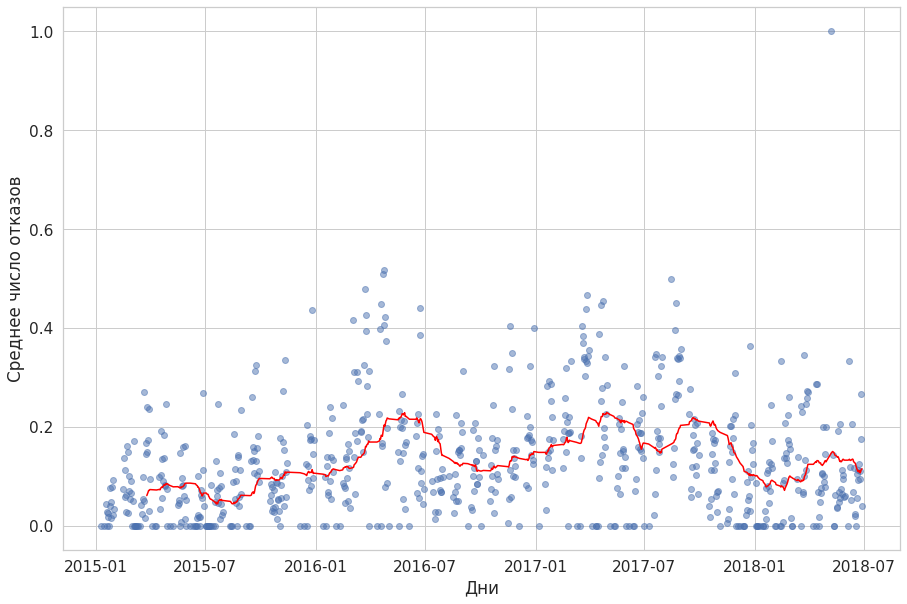

In [12]:
get_data(graph_1)

plt.figure(figsize=(15, 10))
plt.scatter(graph_1['date_time'], graph_1['mean_target'], alpha=0.5)
plt.plot(graph_1['date_time'], graph_1['mean_target'].rolling(50).mean(), color='red');
plt.xlabel('Дни')
plt.ylabel('Среднее число отказов')
plt.show()

Видно, что у нас есть один выброс в 2018 году. Вероятнее всего, в этот день померили одну сломанную дорогу и все. Поэтому для большей наглядности выкинем этот день.

In [13]:
graph_1 = graph_1.drop(graph_1[graph_1['mean_target'] == 1].index)

И снова построим графи + общее число отказов

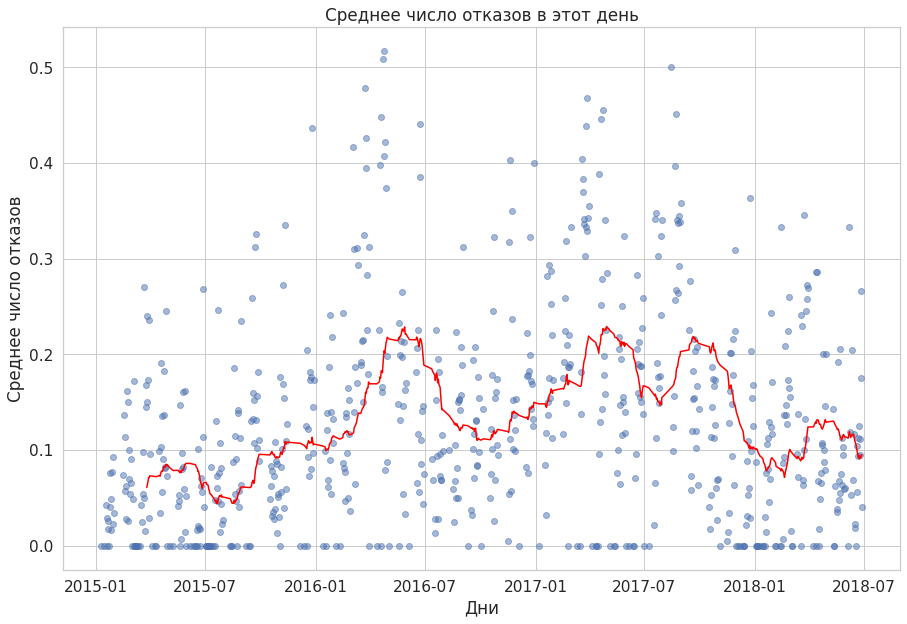

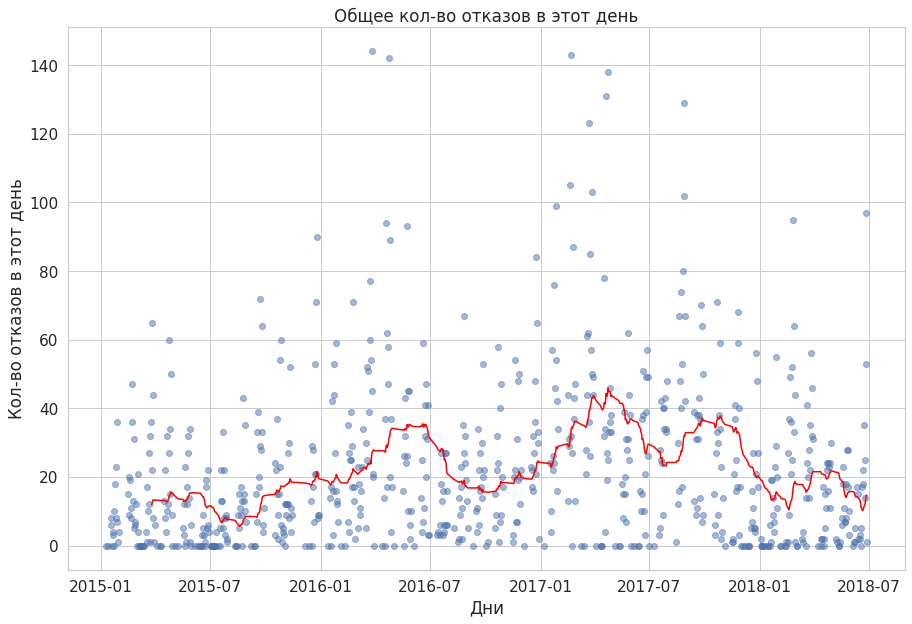

In [14]:
plt.figure(figsize=(15, 10))
plt.scatter(graph_1['date_time'], graph_1['mean_target'], alpha=0.5)
plt.plot(graph_1['date_time'], graph_1['mean_target'].rolling(50).mean(), color='red');
plt.xlabel('Дни')
plt.ylabel('Среднее число отказов')
plt.title('Среднее число отказов в этот день')
plt.show()

graph_3 = df.groupby(["MONTH_ORDERED", "DAY"], as_index=False) \
    .aggregate({"TARGET": "sum"}) \
    .rename(columns = {"TARGET": "sum"})
get_data(graph_3)

plt.figure(figsize=(15, 10))
plt.scatter(graph_3['date_time'], graph_3['sum'], alpha=0.5)
plt.plot(graph_3['date_time'], graph_3['sum'].rolling(50).mean(), color='red');
plt.xlabel('Дни')
plt.ylabel('Кол-во отказов в этот день')
plt.title('Общее кол-во отказов в этот день')
plt.show()

## Что я заметил
### Зимой кол-во отказов в летние месяцы в среднем меньше, чем в зимние месяцы за тот же год. 
Предположение 1. Летом рельсы под воздействием тепла больше склонны дифформироваться => выходить из строя

Предположение 2. Летом проводится больше измерений различных путей ЖД путей и мне кажется, что чем больше измерерний делается, тем больше отказов находят. 

### Хочу проверить предположение 2. 
Для этого строю график "Какое кол-во путей в день проверяется"

In [15]:
graph_2 = df.groupby(["MONTH_ORDERED", "DAY"], as_index=False) \
    .aggregate({"TARGET": "count"}) \
    .rename(columns = {"TARGET": "count"})

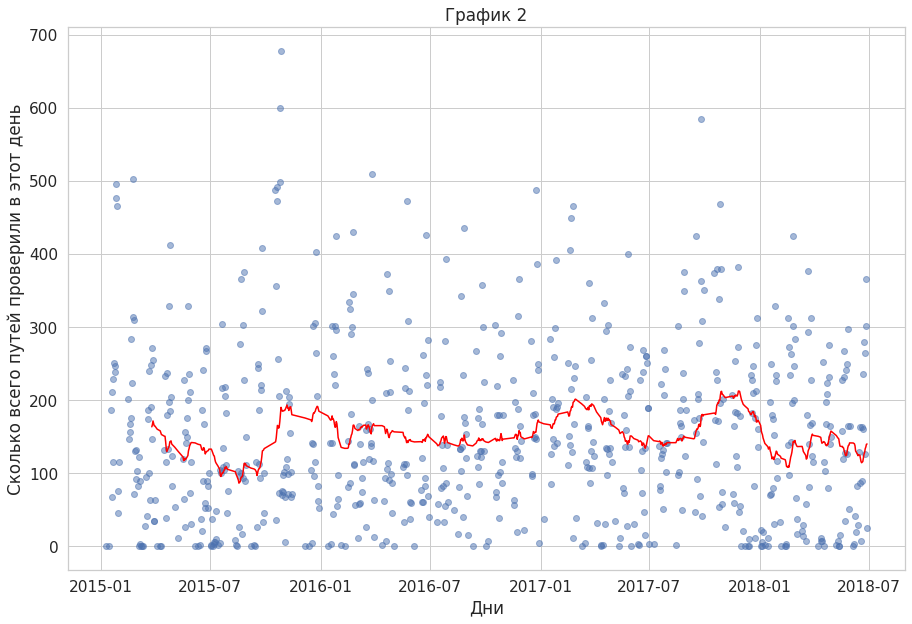

In [16]:
get_data(graph_2)

plt.figure(figsize=(15, 10))
plt.scatter(graph_2['date_time'], graph_2['count'], alpha=0.5)
plt.plot(graph_2['date_time'], graph_2['count'].rolling(50).mean(), color='red');
plt.xlabel('Дни')
plt.ylabel('Сколько всего путей проверили в этот день')
plt.title('График 2')
plt.show()

## Вывод из по этим трем графикам

### Видно, что в среднем  +- одинаковое кол-во проверок, НО 

Два горба в первой половине 2017 и конце 2017 года, совпадает с такими же горбами в 1-ом графике. Т.е. есть зависимость между ними все-таки. В принципе, можно сделать вывод, что кол-во отказов тем больше, чем больше в общей сложности было произведено проверок.

Но если посмотреть на лето 2016 года, то эта гипотеза не работает.

# Пишем сетку

In [17]:
np_df = df.drop(['TARGET', 'M', 'Unnamed: 0'], axis = 1).values
np_labels = np.array(df.TARGET)

In [18]:
blade = 92347 # Последние полгода
X, X_test, y, y_test = np_df[:blade], np_df[blade:], np_labels[:blade], np_labels[blade:] # train_test_split(np_df, np_labels, test_size=0.2, random_state=10)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=10)

Переведем все в torch.tensor

In [19]:
X_train_t = torch.FloatTensor(X_train) 
y_train_t = torch.FloatTensor(y_train) 
X_test_t = torch.FloatTensor(X_test) 
y_test_t = torch.FloatTensor(y_test) 
X_valid_t = torch.FloatTensor(X_valid) 
y_valid_t = torch.FloatTensor(y_valid) 

In [20]:
X_valid_t.shape, X_train_t.shape, X_test_t.size()

(torch.Size([18470, 155]), torch.Size([73877, 155]), torch.Size([15250, 155]))

## Напишем сетку

In [21]:
class RZDNet(torch.nn.Module):
    def __init__(self, in_features, n_hidden_neurons):
        super(RZDNet, self).__init__()
        self.fc1 = torch.nn.Linear(in_features, n_hidden_neurons)
        self.ac1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons) 
        self.ac2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons) 
        self.ac3 = torch.nn.ReLU()
        self.fc4 = torch.nn.Linear(n_hidden_neurons, 1) 
        self.ac4 = torch.nn.Sigmoid()
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        x = self.fc4(x)
        x = self.ac4(x)
        
        return x

При дальнейшем увеличении количества слоев и количества нейронов в слое, метрика roc_auc почти не дает прироста, поэтому пока остановился на этом варианте.

In [22]:
def get_best_threshold(y, y_pred):
    y_pred = y_pred
    fpr, tpr, th = roc_curve(y, y_pred)

    # Геометрическое среднее
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = argmax(gmeans)
    best_thresh = th[ix]
    
    return best_thresh

Всякие штуки, для работы на GPU (у меня по дефолту gpu)

In [23]:
# torch.cuda.is_available()

In [24]:
# !nvidia-smi

In [25]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# mnist_net = mnist_net.to(device)
# list(mnist_net.parameters())

In [26]:
rzd_net = RZDNet(X_train_t.shape[1], 50)

In [27]:
loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(rzd_net.parameters(), lr=1e-4)

In [28]:


batch_size = 1000
valid_accuracy_history = []
valid_loss_history = []
train_loss_history = []

# X_test = X_test.to(device)
# y_test = y_test.to(device)

for epoch in trange(150):
    order = np.random.permutation(len(X_train_t))
    
    history = {
        'train_loss':[],
        'val_loss':[],
        'train_score':[],
        'val_score':[]
    }
    
    train_batch_loss_history = 0
    for start_index in range(0, len(X_train_t), batch_size):
        batch_indexes = order[start_index: start_index + batch_size]
        
        X_batch_t = X_train_t[batch_indexes] #.to(device)
        y_batch_t = y_train_t[batch_indexes] #.to(device)

        preds = rzd_net.forward(X_batch_t)   
        preds = preds.flatten()
        loss_value = loss(preds, y_batch_t)
        
        train_batch_loss_history += loss_value
        loss_value.backward()
        
        optimizer.step()
        optimizer.zero_grad()      
        
        
    train_batch_loss_history /= batch_size
    train_loss_history.append(train_batch_loss_history)
    
    with torch.no_grad():
        y_valid_pred = rzd_net.forward(X_valid_t)
        y_valid_pred = y_valid_pred.flatten()
        valid_loss_history.append(loss(y_valid_pred, y_valid_t))

        y_valid_pred = y_valid_pred.detach().numpy()
        best_thresh = get_best_threshold(y_valid, y_valid_pred)    
        valid_accuracy_history.append(
            balanced_accuracy_score(y_valid.reshape(-1), (y_valid_pred  > best_thresh).astype(int)))

#     print(f'Best Threshold={best_thresh:.4f}')
#     print(f'balanced_score_{epoch}=: {balanced_accuracy_score(y_valid.reshape(-1), (y_valid_pred  > best_thresh).astype(int)):.4f}\n')

100%|██████████| 150/150 [00:29<00:00,  5.02it/s]


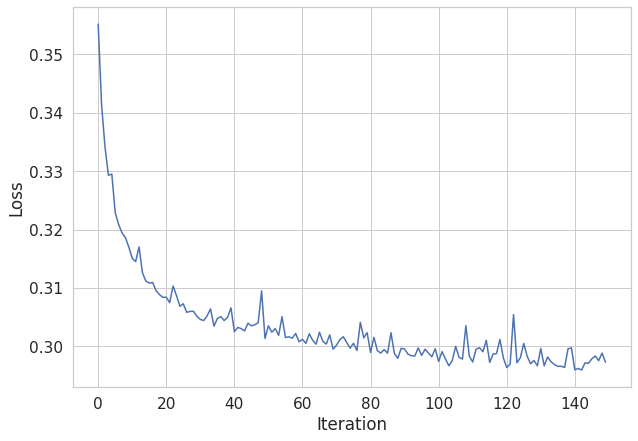

In [29]:
plt.figure(figsize=(10, 7))
plt.plot(range(len(valid_loss_history)), valid_loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

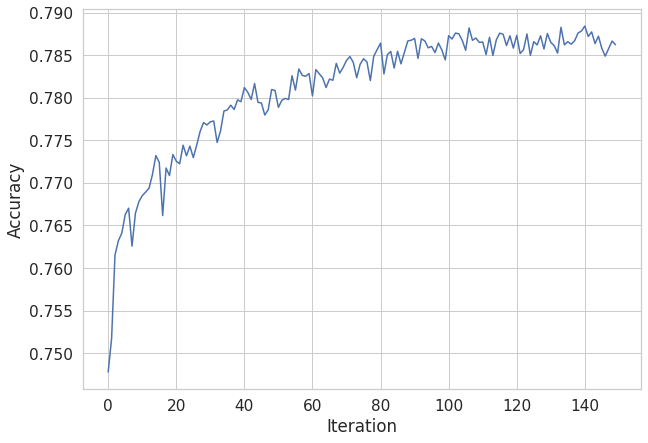

In [30]:
plt.figure(figsize=(10, 7))
plt.plot(range(len(valid_accuracy_history)), valid_accuracy_history)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

## Построим ROC_AUC кривую

In [31]:
y_test_pred = (rzd_net.forward(X_test_t).detach().numpy()) # > th).astype(int)
y_train_pred = (rzd_net.forward(X_train_t).detach().numpy()) # > th).astype(int)

In [32]:
train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

In [33]:
fpr, tpr, th = roc_curve(y_train, y_train_pred)
gmeans = np.sqrt(tpr * (1-fpr))
ix = argmax(gmeans)

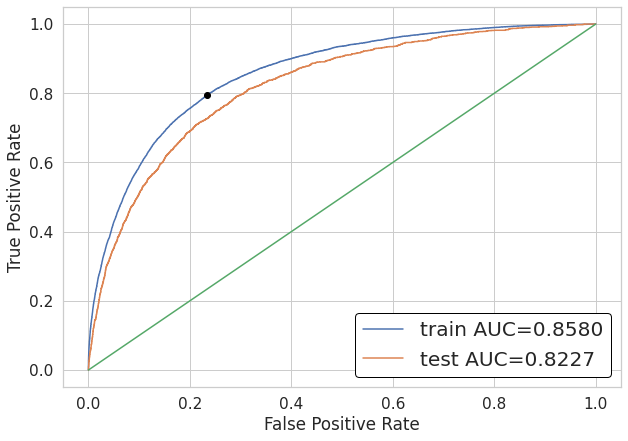

In [34]:
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_pred)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_pred)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
plt.plot(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [35]:
rzd_net.parameters

<bound method Module.parameters of RZDNet(
  (fc1): Linear(in_features=155, out_features=50, bias=True)
  (ac1): ReLU()
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (ac2): ReLU()
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (ac3): ReLU()
  (fc4): Linear(in_features=50, out_features=1, bias=True)
  (ac4): Sigmoid()
)>

## Сравним по приколу с sklearn

In [36]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=100, hidden_layer_sizes=(100,100,100), activation='relu', solver='adam')
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100, 100), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [37]:
#clf.best_params_ {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100), 'solver': 'adam'}

In [38]:
y_test_pred_MLP = mlp.predict_proba(X_test)[:,1]
y_train_pred_MLP = mlp.predict_proba(X_train)[:,1]

In [39]:
y_test_pred.shape, y_test.shape, X_test.shape, y_test_pred_MLP.shape

((15250, 1), (15250,), (15250, 155), (15250,))

In [40]:
train_auc = roc_auc_score(y_train, y_train_pred_MLP)
test_auc = roc_auc_score(y_test, y_test_pred_MLP)
train_auc, test_auc

(0.8614146259856846, 0.8277386640159841)

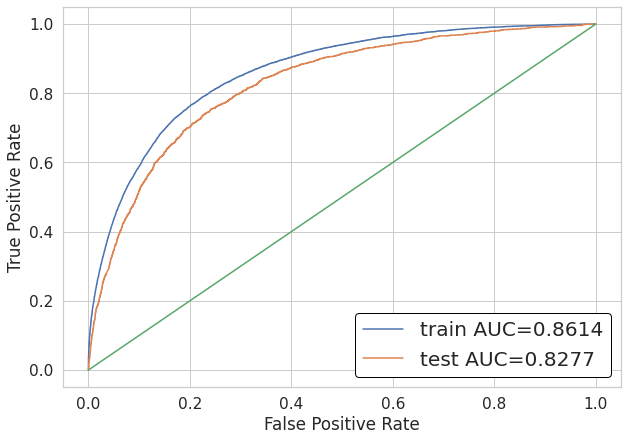

In [41]:
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_pred_MLP)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_pred_MLP)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Получили тоже самое. Это хорошо:)

## Covariate shift

In [42]:
np_df = df.drop(['TARGET', 'M', 'Unnamed: 0'], axis = 1).values
np_labels = np.array(df.TARGET)

In [43]:
blade = 92347 # Последние полгода

# Разобьем на трейн-тест выборку
X_train, X_test, y_train, y_test = np_df[:blade], np_df[blade:], np_labels[:blade], np_labels[blade:]

In [44]:
train = pd.DataFrame(X_train)
test = pd.DataFrame(X_test)

In [45]:
test['is_train'] = 0
train['is_train'] = 1

In [46]:
#объединение выборок train, test
df_combine = pd.concat([train, test], axis=0, ignore_index=True)

y = df_combine['is_train'].values #индикатор источника 
x = df_combine.drop('is_train', axis=1).values #объединенный датасет

In [47]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

rfc = RandomForestClassifier(n_jobs=-1, max_depth=5, min_samples_leaf = 5)
predictions = np.zeros(y.shape)

In [48]:
# Используем стратифицированное рандомизированное разбиение на 4 фолда. 
# Таким образом мы сохраним соотношение меток 'is_train' в каждом фолде, 
# как в исходной объединенной выборке. Для каждого разбиенения обучим 
# классификатор на большей части разбиения и предскажем метку класса для меньшей отложенной части.

from sklearn.model_selection import StratifiedKFold, cross_val_score
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=100)
skf.split(x, y)
for fold, (train_idx, test_idx) in enumerate(skf.split(x, y)):
    X_train, X_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
 
    rfc.fit(X_train, y_train)
    probs = rfc.predict_proba(X_test)[:, 1] #предсказание вероятностей классов
    predictions[test_idx] = probs

In [49]:
print('ROC-AUC:', roc_auc_score(y_true=y, y_score=predictions))

ROC-AUC: 0.9999615747234195


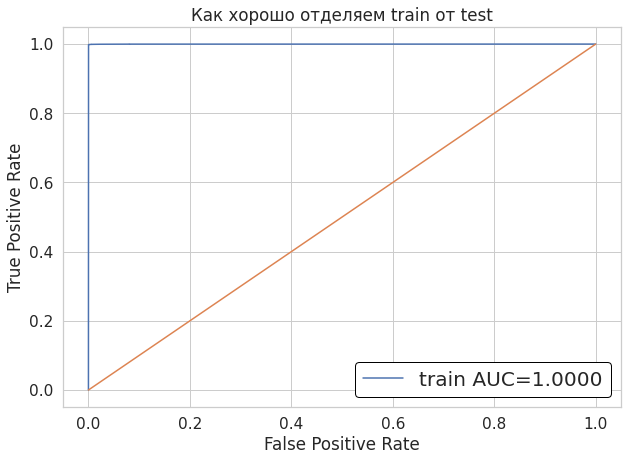

In [50]:
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y, predictions)[:2], label='train AUC={:.4f}'.format(roc_auc_score(y, predictions)))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Как хорошо отделяем train от test')
plt.show()

Без one-hot энкодддинга и без признака MONTH_ORDERED: ROC_AUC = 0.8973

С ними: ROC_AUC = 0.9919

### Вывод:
Получается что One-hot энкоддинг + новый признак MONTH_ORDERED помогают не только увеличить скор, но также дают значительное улучшение при отделении train от test, что в принципе не удивительно.

## Теперь обучим на тех данных, которые похожи на test

In [51]:
train.shape, test.shape, np_df.shape, y_train.shape

((92347, 156), (15250, 156), (107597, 155), (80698,))

Снова разобьем на train test

In [52]:
X_train, X_test, y_train, y_test = np_df[:blade], np_df[blade:], np_labels[:blade], np_labels[blade:]

Делаем маску с объектами, которые больше похожи на тестовую выборку. 

In [53]:
mask = rfc.predict_proba(X_train)[:,1] > 0.8
mask.shape

(92347,)

In [54]:
X_similar = X_train[mask]
y_similar = y_train[mask]

In [55]:
X_similar.shape, y_similar.shape

((87720, 155), (87720,))

In [56]:
mlp = MLPClassifier(max_iter=100, hidden_layer_sizes=(100,100,100), activation='relu', solver='adam')
mlp.fit(X_similar, y_similar);

In [57]:
y_test_pred = mlp.predict_proba(X_test)[:,1]
y_similar_pred = mlp.predict_proba(X_similar)[:,1]

In [58]:
train_auc = roc_auc_score(y_similar, y_similar_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

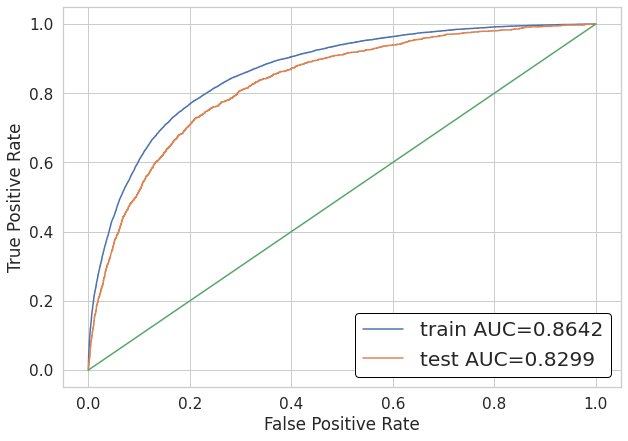

In [59]:
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_similar, y_similar_pred)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_pred)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Получилось что-то совсем странное. Как будто отказы предсказывает хорошо, а НЕотказы плохо (или наоборот)

In [60]:
y_test_pred = []
y_similar_pred = []

for i in np.arange(0.4, 0.7, 0.1):
    mask = rfc.predict_proba(X_train)[:,1] > i

    X_similar = X_train[mask]
    y_similar = y_train[mask]

    print(X_similar.shape, y_similar.shape)

    mlp = MLPClassifier(max_iter=100, hidden_layer_sizes=(100,100,100), activation='relu', solver='adam')
    mlp.fit(X_similar, y_similar);

    y_test_pred.append(mlp.predict_proba(X_test)[:,1])
    y_similar_pred.append(mlp.predict_proba(X_similar)[:,1])

(92347, 155) (92347,)
(92347, 155) (92347,)
(92343, 155) (92343,)


In [61]:
y_similar_pred.shape()

fig, ax = plt.subplots(nrows=2, ncols=2)

for row in ax:
    for col in row:
        col.plot(*roc_curve(y_similar, y_similar_pred)[:2])
        col.plot(*roc_curve(y_test, y_test_pred)[:2])

plt.show()

AttributeError: ignored

In [ ]:
# Какой-то код

# Нормализация данных
# x = df.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df = pd.DataFrame(x_scaled)


# Класс на глаз
# n_hidden_neurons = 50
# rzd_net = torch.nn.Sequential(
#     torch.nn.Linear(X_train_t.shape[1], n_hidden_neurons),
#     torch.nn.LeakyReLU(),
#     torch.nn.Linear(n_hidden_neurons, n_hidden_neurons),
#     torch.nn.LeakyReLU(),
#     torch.nn.Linear(n_hidden_neurons, n_hidden_neurons),
#     torch.nn.LeakyReLU(),
#     torch.nn.Linear(n_hidden_neurons, n_hidden_neurons),
#     torch.nn.LeakyReLU(),
#     torch.nn.Linear(n_hidden_neurons, 1),
#     torch.nn.Sigmoid()
# )

# fpr, tpr, thresholds = roc_curve(y_test, rzd_net.forward(X_test_t).detach().numpy())
# # get the best threshold
# J = tpr - fpr
# ix = argmax(J)
# best_thresh = thresholds[ix]
# print(f'Best Threshold={best_thresh}')
# print(f'Best roc_auc_score={roc_auc_score(y_test, (rzd_net.forward(X_test_t).detach().numpy() > 
# best_thresh).astype(int))}')


# import xgboost as xgb
# dtrain = xgb.DMatrix(x, y)
# params = {"objective": "binary:logistic", "max_depth": 6, "eta": 0.1, "min_child_weight": 10, 
#           "gamma": 0.75, "subsample": 0.8, "colsample_bytree": 0.95, "eval_metric": "auc"}
# num_rounds = 46
# xgb_model = xgb.train(params, dtrain, num_rounds)
# pred = xgb_model.predict(dtrain)